In [2]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
ROBOFLOW_WORKSPACE = os.getenv("ROBOFLOW_WORKSPACE")
ROBOFLOW_PROJECT = os.getenv("ROBOFLOW_PROJECT")

## Download

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("rail-h9koe").project("rail-sem")
version = project.version(5)
dataset = version.download("yolov8", location=r"rail-sem")

## Train

In [ ]:
import os
import torch
from ultralytics import YOLO

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the data YAML file
data_yaml_path = os.path.join(current_dir, 'rail-sem', 'data.yaml')

# Define training parameters
epochs = 50
imgsz = 640  # Image size for training
batch = 16   # Batch size for training
weights = 'yolov8n.pt'  # Pre-trained model weights

# Set the device to use (CUDA if available, MPS if on Mac)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Initialize and train the YOLOv8 model
model = YOLO(weights)

# Add debug logging
print(f"Data YAML path: {data_yaml_path}")
print(f"Device: {device}")

model.train(data=data_yaml_path, epochs=epochs, imgsz=imgsz, batch=batch, device=str(device))

# Optionally, you can save the trained model
model.save(os.path.join(current_dir, 'models', 'yolov8n.pt'))

## Upload

In [ ]:
from roboflow import Roboflow

# Initialize Roboflow using your API key
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# Create a new project or use existing one
workspace = rf.workspace(ROBOFLOW_WORKSPACE)
project = workspace.project(ROBOFLOW_PROJECT)

workspace.upload_dataset(
    dataset_path=r"/Users/milan.jelisavcic/Projects/railguard/notebooks/rail-sem",
    project_name=ROBOFLOW_PROJECT,
    dataset_format="yolov8",
    # split=True
)

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...
Uploading to existing project railguard/railstuff
[UPLOADED] /Users/milan.jelisavcic/Projects/railguard/notebooks/rail-sem/test/images/rs00421_jpg.rf.e52e9b09bc8dd84a48946ef07340244e.jpg (qVaDizzwG4KAlpvCCLEZ) [2.9s] / annotations = ERR: Annotation not found.
[UPLOADED] /Users/milan.jelisavcic/Projects/railguard/notebooks/rail-sem/test/images/rs00314_jpg.rf.ea62eef5e9996a8af06dc562878a38ec.jpg (kCKFlnIHf29TE7iKK1tm) [2.9s] / annotations = ERR: Annotation not found.
[UPLOADED] /Users/milan.jelisavcic/Projects/railguard/notebooks/rail-sem/test/images/rs00525_jpg.rf.f7f210bf4c956bb59c068532eaddf29f.jpg (uIH4BXdEY2czewT8BjvA) [2.6s] / annotations = OK [0.7s]
[UPLOADED] /Users/milan.jelisavcic/Projects/railguard/notebooks/rail-sem/test/images/rs00199_jpg.rf.b0b96238c312ce0230541604e94de884.jpg (6ScxGviHRe8nQpnQSbWR) [2.7s] / annotations = OK [0.7s]
[UPLOADED] /Users/milan.jelisavcic/Projects/railguard/note

In [4]:
from roboflow import Roboflow

# Initialize Roboflow using your API key
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# Create a new project or use existing one
workspace = rf.workspace(ROBOFLOW_WORKSPACE)
project = workspace.project(ROBOFLOW_PROJECT)

# # Now deploy the model to this version
project.version(1).deploy(model_path="/Users/milan.jelisavcic/Projects/railguard/notebooks/", model_type="yolov8", filename="and_yolov8n.pt")

loading Roboflow workspace...
loading Roboflow project...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


View the status of your deployment at: https://app.roboflow.com/railguard/railstuff/1


## Test

In [7]:
import requests
import base64
import json

MODEL_VERSION = 1
# Your API URL should look like this:
api_url = f"https://detect.roboflow.com/{ROBOFLOW_PROJECT}/{MODEL_VERSION}?api_key={ROBOFLOW_API_KEY}"

# For a local image
with open("/Users/milan.jelisavcic/Projects/railguard/notebooks/car_on_tracks_1.jpg", "rb") as image_file:
    image_data = base64.b64encode(image_file.read()).decode("utf-8")

# Make prediction request
response = requests.post(
    api_url,
    data=json.dumps({
        "image": image_data
    }),
    headers={
        "Content-Type": "application/json"
    }
)

predictions = response.json()
print(predictions)

{'message': 'Could not load input image. Cause: Malformed base64 input image.'}


loading Roboflow workspace...
loading Roboflow project...
Predictions: {'predictions': [{'x': 422.0, 'y': 132.5, 'width': 68.0, 'height': 183.0, 'confidence': 0.7298622131347656, 'class': 'person', 'class_id': 1, 'detection_id': 'f2f9b77f-b300-40a8-8567-6252f696d733', 'image_path': 'istockphoto-622046436-612x612.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '612', 'height': '408'}}


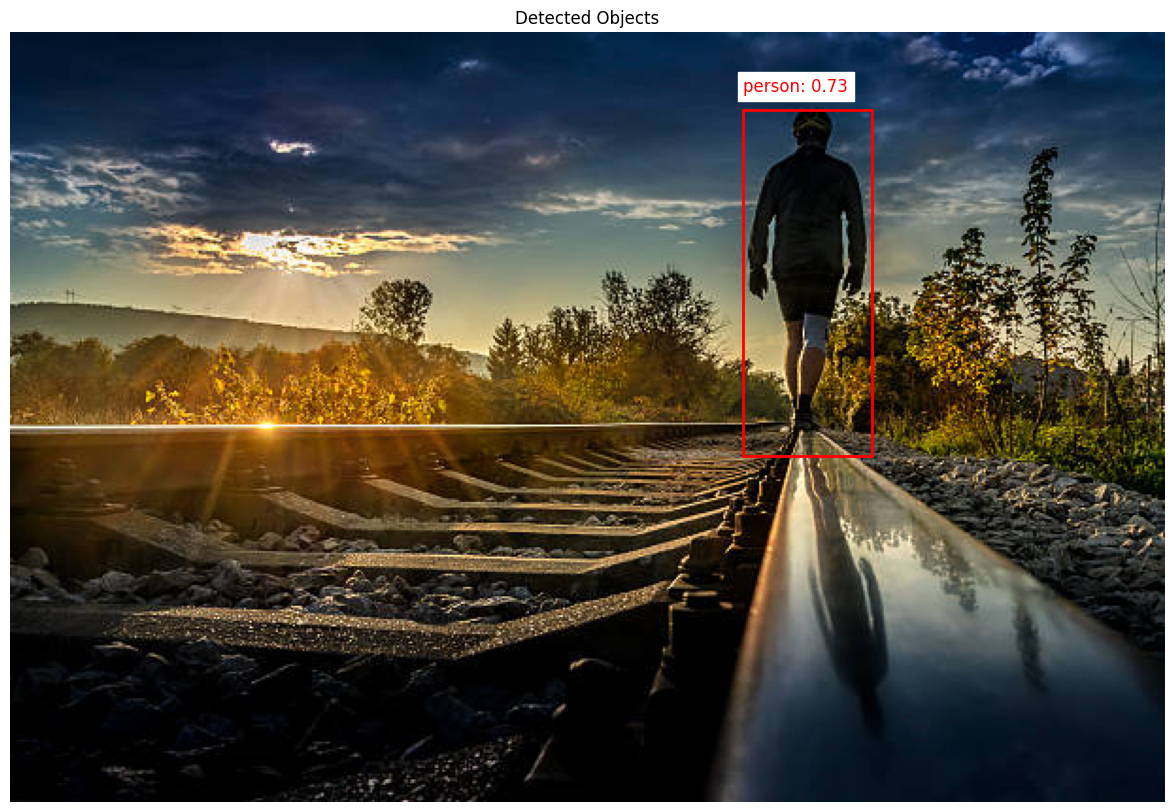


Detected objects:
- person (Confidence: 0.73)


In [4]:
# Import required libraries
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
import requests
import numpy as np

def download_image(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        return True
    return False

def display_image_with_predictions(image_path, predictions):
    print(f"Predictions: {predictions}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    
    for prediction in predictions['predictions']:
        class_name = prediction['class']
        confidence = prediction['confidence']
        x = prediction['x']
        y = prediction['y']
        width = prediction['width']
        height = prediction['height']
        
        x1 = int(x - width/2)
        y1 = int(y - height/2)
        x2 = int(x + width/2)
        y2 = int(y + height/2)
        
        plt.gca().add_patch(plt.Rectangle((x1, y1), width, height,
                                        fill=False, color='red', linewidth=2))
        
        plt.text(x1, y1-10, f'{class_name}: {confidence:.2f}',
                color='red', fontsize=12, backgroundcolor='white')
    
    plt.imshow(image)
    plt.axis('off')
    plt.title('Detected Objects')
    plt.show()
    
    print("\nDetected objects:")
    for pred in predictions['predictions']:
        print(f"- {pred['class']} (Confidence: {pred['confidence']:.2f})")

def main():
    image_path = "car_on_tracks_1.jpg"
    image_path = "istockphoto-622046436-612x612.jpg" #"istockphoto-2128229638-612x612.webp"
    # image_path = "5678a73b5da645073e7b23c6.w800.jpg"
    
    # url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/GAZ-13_Chaika_draisine.jpg/991px-GAZ-13_Chaika_draisine.jpg"
    # image_path = "downloaded_image.jpg"
    # if download_image(url, image_path):
    #     print("Image downloaded successfully")
    # else:
    #     raise Exception("Failed to download image")
    
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    project = rf.workspace(ROBOFLOW_WORKSPACE).project(ROBOFLOW_PROJECT)
    model = project.version(1).model
    predictions = model.predict(image_path, confidence=40, overlap=30).json()
    
    display_image_with_predictions(image_path, predictions)

if __name__ == "__main__":
    main()

In [ ]:
import sys
import os

# Add root directory to Python path
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="OqH8tRmlNXst2MdXI893")
project = rf.workspace("jet-znmu4").project("help_me")
version = project.version(5)
dataset = version.download("coco-segmentation")

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="OqH8tRmlNXst2MdXI893")
project = rf.workspace("jet-znmu4").project("help_me")
version = project.version(5)
dataset = version.download("coco-segmentation")

In [ ]:
from comparator.config import CONFIG
from comparator.dataset import DatasetManager

dataset = DatasetManager(CONFIG)

# Download YOLOv8 format
yolo_path = dataset.download(data_format="yolov8")

# Or download COCO format
coco_path = dataset.download(data_format="coco")

In [ ]:
from comparator.config import CONFIG
from comparator.trainer import RailTrackModelComparison

# Initialize comparison framework
comparison = RailTrackModelComparison(CONFIG)

# Run complete comparison
comparison.run_comparison()